# Convolutional Neural Networks (CNNs) with PyTorch

**Authors:** Jeffrey Huang and Alex Michels

In this notebook, we will use PyTorch CNNs to recognize text from images. We use CNNs in this use case because the individual values of pixels don't tell us very much, but convolutions can help us extract features.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import time
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import optim
from torch.autograd import Variable
import torch.nn as nn

## Data Wrangling

First, we need to download the built in PyTorch MNIST dataset:

In [2]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False,
    transform = ToTensor()
)

Next, we will examine the data. The data is of arrays based on the color of the pixel. We can also plot our data to see the images they make:

In [3]:
test_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

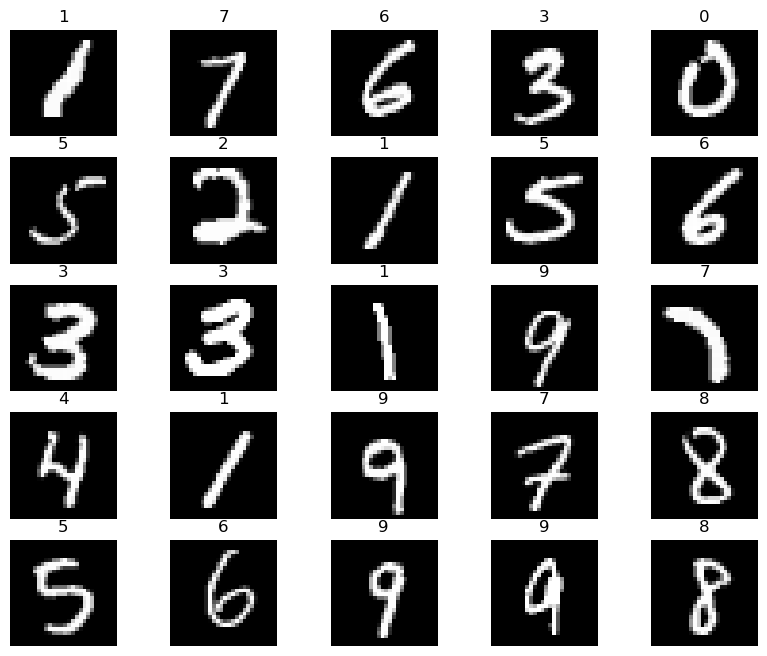

In [4]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

DataLoaders are necessary for letting the model process large datasets.

In [5]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),
    'test' : torch.utils.data.DataLoader(test_data,
                                         batch_size=100,
                                         shuffle=True,
                                         num_workers=1)
}

## Creating the Model

Next, we define the model as well as its forward pass function. This is a fairly simple CNN with 2 convolutional layers.

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,  # (int) -> number of channels in input image    =1 because output is grayscale image
                out_channels=16, # (int) -> number of channels produced by the convolution
                kernel_size=5, # (int, tuple) -> size of convolving kernel
                stride=1, # (int, tuple, optional) -> stride of convolution, default is 1
                padding=2, # (int, tuple, optional) -> zero-padding added to both sides of input, default is 0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x       

In [7]:
cnn = CNN()

Next we define the loss function and optimizer. Cross Entropy Loss is a loss function for classification problems, while Adam is a popular and powerful optimizer that extends the already effective stochastic gradient descent algorithm.

In [8]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.01)  

It is worthwhile to check and make sure what device we are running on. 

In [9]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu



## Training the Model

Next is the training step. 

**As this is a convolutional neural network being trained on a large image dataset, expect training time to take much longer than for a simple linear regression model. It is also worthwhile to time the training loop.**

In [10]:
start_time = time.time()

num_epochs = 5
def train(num_epochs, cnn, loaders):
    cnn.train()
    total_step = len(loaders['train'])
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            # gives batch data, normalizes x when iterating train_loader
            b_x = Variable(images)
            b_y = Variable(labels)
            
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)

            # clear gradients for this trainign step
            optimizer.zero_grad()
            # backpropogation, computing gradients
            loss.backward()
            # apply gradients
            optimizer.step()
            if (i+1) & 100 == 0:
                print('Epoch [{}/{}], Step[{}/{}], Loss: {:.4f}'
                      .format(epoch + 1, num_epochs, i+1, total_step, loss.item()))
                pass
            pass
        pass
train(num_epochs, cnn, loaders)

curr_time = time.time()
print(f"Training took {curr_time - start_time} seconds")

Epoch [1/5], Step[1/600], Loss: 2.3010
Epoch [1/5], Step[2/600], Loss: 2.7873
Epoch [1/5], Step[3/600], Loss: 2.2077
Epoch [1/5], Step[8/600], Loss: 1.4460
Epoch [1/5], Step[9/600], Loss: 1.1443
Epoch [1/5], Step[10/600], Loss: 0.8667
Epoch [1/5], Step[11/600], Loss: 0.9214
Epoch [1/5], Step[16/600], Loss: 1.0815
Epoch [1/5], Step[17/600], Loss: 0.5077
Epoch [1/5], Step[18/600], Loss: 1.0005
Epoch [1/5], Step[19/600], Loss: 0.6165
Epoch [1/5], Step[24/600], Loss: 0.4259
Epoch [1/5], Step[25/600], Loss: 0.3769
Epoch [1/5], Step[26/600], Loss: 0.3689
Epoch [1/5], Step[27/600], Loss: 0.3474
Epoch [1/5], Step[128/600], Loss: 0.0309
Epoch [1/5], Step[129/600], Loss: 0.0608
Epoch [1/5], Step[130/600], Loss: 0.0554
Epoch [1/5], Step[131/600], Loss: 0.2005
Epoch [1/5], Step[136/600], Loss: 0.1554
Epoch [1/5], Step[137/600], Loss: 0.2146
Epoch [1/5], Step[138/600], Loss: 0.0350
Epoch [1/5], Step[139/600], Loss: 0.0702
Epoch [1/5], Step[144/600], Loss: 0.1806
Epoch [1/5], Step[145/600], Loss: 0.

## Testing the Model

Let's define a testing function for model evaluation:

In [11]:
def test():
    cnn.eval()  # set to evaluation mode
    with torch.no_grad():  # don't update gradients during testing
        correct = 0
        total = 0
        for images, labels in loaders['test']:  # for each item in the test set, test it
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
    print('Test accuracy of model on 10000 test images: %.2f' % accuracy)

In [12]:
test()  # this takes a minute

Test accuracy of model on 10000 test images: 1.00


Let's grab a few samples from our test set, plot them, and then manually check our accuracy:

In [13]:
sample = next(iter(loaders['test']))
imgs, lbls = sample
actual_number = lbls[:10].numpy()

Plotting the samples:

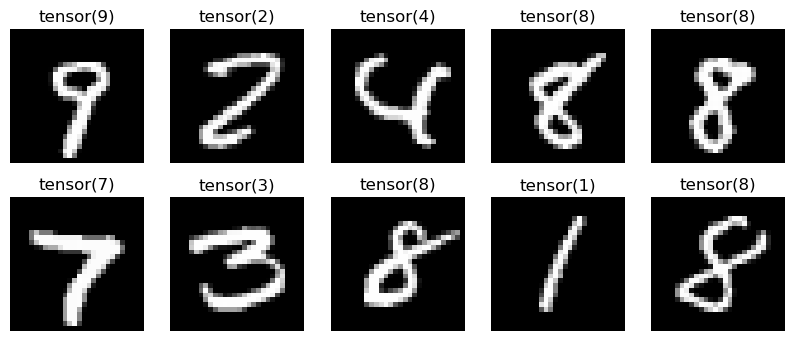

In [14]:
figure = plt.figure(figsize=(10, 4))
cols, rows = 5, 2
for i in range(1, cols * rows + 1):
    img, label = imgs[i], lbls[i]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Checking our prediction abilities on our 10 samples:

In [15]:
test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [0 9 2 9 8 8 7 3 8 1]
Actual number: [0 9 2 4 8 8 7 3 8 1]


## Saving The Trained Model

Next, we can save the trained model's state using the lines below:

In [16]:
# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_mnist_cnn.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=cnn.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)


Saving model to: models/01_pytorch_mnist_cnn.pth


In [17]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = CNN()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [18]:
loaded_model_0.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loaders['test']:
        test_output, last_layer = loaded_model_0(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        pass
print('Test accuracy of model on 10000 test images: %.2f' % accuracy)

Test accuracy of model on 10000 test images: 0.99
